<a href="https://colab.research.google.com/github/Bloch-AI/BlochAI-PythonProgrammingforAI/blob/master/K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **K-Means Clustering**

K-means is a clustering algorithm that helps group similar data points together based on their features. Imagine you're a marketer segmenting your audience, a lawyer organizing documents by topic, or a fraud analyst identifying transaction patterns. K-means works by first choosing the number of clusters (k) and randomly placing centroids (cluster centers). Each data point is assigned to the closest centroid, and the centroids are then updated to be the average (mean) of all points in their cluster. This process repeats until the centroids stop moving.

K-means follows two key principles:


*   It minimizes the distance between points in the same cluster—so each centroid
is as close as possible to its assigned points.
*   It maximizes the distance between clusters, ensuring clear separation between groups.

By continuously refining the centroids, K-means creates tight, well-separated clusters that reveal meaningful patterns in the data.

In [1]:
from google.colab import files
files.upload()   # This will open a file picker dialog

Saving kmeans_blobs.csv to kmeans_blobs.csv


{'kmeans_blobs.csv': b'ID,x,y,cluster\r\n0,24.412,32.932,2\r\n1,35.19,12.189,1\r\n2,26.288,41.718,2\r\n3,0.376,15.506,0\r\n4,26.116,3.963,1\r\n5,25.893,31.515,2\r\n6,23.606,15.402,1\r\n7,28.026,15.47,1\r\n8,26.36,34.488,2\r\n9,23.013,36.213,2\r\n10,27.819,41.867,2\r\n11,39.634,42.23,2\r\n12,35.477,35.104,2\r\n13,25.768,5.967,1\r\n14,-0.684,21.105,0\r\n15,3.387,17.81,0\r\n16,32.986,3.412,1\r\n17,34.258,9.931,1\r\n18,6.313,29.426,0\r\n19,33.899,37.535,2\r\n20,4.718,12.125,0\r\n21,21.054,5.067,1\r\n22,3.267,21.911,0\r\n23,24.537,38.822,2\r\n24,4.55,16.179,0\r\n25,25.712,7.409,1\r\n26,3.884,28.616,0\r\n27,29.081,34.539,2\r\n28,14.943,23.263,0\r\n29,32.169,45.421,2\r\n30,32.572,16.944,1\r\n31,33.673,13.163,1\r\n32,29.189,13.226,1\r\n33,25.994,34.444,2\r\n34,16.513,23.396,0\r\n35,23.492,11.142,1\r\n36,26.878,36.609,2\r\n37,31.604,36.911,2\r\n38,34.078,33.827,2\r\n39,11.286,16.082,0\r\n40,30.15,9.642,1\r\n41,36.569,45.827,2\r\n42,3.983,11.839,0\r\n43,12.891,23.832,0\r\n44,21.314,13.264,1\r\n4

# Getting Started: K-Means from First Principles
For the purposes of our implementation, we will take a look at some data with 2 attributes for simplicity. We will then look at an example with more dimension. To get us started we will use a dataset we have prepared and it is available here with the name kmeans_blobs.csv. The data set contains 4 columns with the following information:

ID: A unique identifier for the observation

x: Attribute corresponding to an x coordinate

y: Attribute corresponding to a y coordinate

Cluster: An identifier for the cluster the observation belongs to
We will discard column 4 for our analysis, but it may be useful to check the results of the application of
k
-means. We will do this in our second example later on. Let us start by reading the dataset:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

blobs = pd.read_csv('kmeans_blobs.csv')
colnames = list(blobs.columns[1:-1])
blobs.head()

,ID,x,y,cluster
0,0,24.412,32.932,2
1,1,35.190,12.189,1
2,2,26.288,41.718,2
3,3,0.376,15.506,0
4,4,26.116,3.963,1


Let us look at the observations in the dataset. We will use the Cluster column to show the different groups that are present in the dataset. Our aim will be to see if the application of the algorithm reproduces closely the groupings.

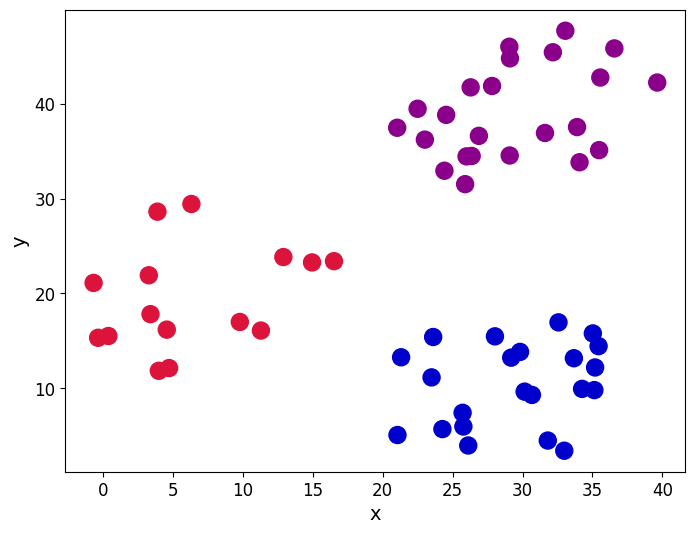

In [3]:
customcmap = ListedColormap(["crimson", "mediumblue", "darkmagenta"])

fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x=blobs['x'], y=blobs['y'], s=150,
            c=blobs['cluster'].astype('category'),
            cmap = customcmap)
ax.set_xlabel(r'x', fontsize=14)
ax.set_ylabel(r'y', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Let's now look at our recipe.

Steps 1 and 2 - Define
k
 and initiate the centroids
First we need 1) to decide how many groups we have and 2) assign the initial centroids randomly. In this case let us consider
k
=
3
, and as for the centroids, well, they have to be in the same range as the dataset itself. So one option is to randomly pick
k
 observations and use their coordinates to initialise the centroids:

In [4]:
def initiate_centroids(k, dset):
    '''
    Select k data points as centroids
    k: number of centroids
    dset: pandas dataframe
    '''
    centroids = dset.sample(k)
    return centroids

np.random.seed(42)
k=3
df = blobs[['x','y']]
centroids = initiate_centroids(k, df)
centroids

,x,y
0,24.412,32.932
5,25.893,31.515
36,26.878,36.609


Step 3 - Calculate distance
We now need to calculate the distance between each of the centroids and the data points. We will assign the data point to the centroid that gives us the minimum error. Let us create a function to calculate the root of square errors:

In [5]:
def rsserr(a,b):
    '''
    Calculate the root of sum of squared errors.
    a and b are numpy arrays
    '''
    return np.square(np.sum((a-b)**2))

Let us pick a data point and calculate the error so we can see how this works in practice. We will use point , which is in fact one of the centroids we picked above. As such, we expect that the error for that point and the third centroid is zero. We therefore would assign that data point to the second centroid. Let’s take a look:

In [6]:
for i, centroid in enumerate(range(centroids.shape[0])):
    err = rsserr(centroids.iloc[centroid,:], df.iloc[36,:])
    print('Error for centroid {0}: {1:.2f}'.format(i, err))

Error for centroid 0: 384.22
Error for centroid 1: 724.64
Error for centroid 2: 0.00


Step 4 - Assign centroids
We can use the idea from Step 3 to create a function that helps us assign the data points to corresponding centroids. We will calculate all the errors associated to each centroid, and then pick the one with the lowest value for assignation:

In [7]:
def centroid_assignation(dset, centroids):
    '''
    Given a dataframe `dset` and a set of `centroids`, we assign each
    data point in `dset` to a centroid.
    - dset - pandas dataframe with observations
    - centroids - pa das dataframe with centroids
    '''
    k = centroids.shape[0]
    n = dset.shape[0]
    assignation = []
    assign_errors = []

    for obs in range(n):
        # Estimate error
        all_errors = np.array([])
        for centroid in range(k):
            err = rsserr(centroids.iloc[centroid, :], dset.iloc[obs,:])
            all_errors = np.append(all_errors, err)

        # Get the nearest centroid and the error
        nearest_centroid =  np.where(all_errors==np.amin(all_errors))[0].tolist()[0]
        nearest_centroid_error = np.amin(all_errors)

        # Add values to corresponding lists
        assignation.append(nearest_centroid)
        assign_errors.append(nearest_centroid_error)

    return assignation, assign_errors

Let us add some columns to our data containing the centroid assignations and the error incurred. Furthermore, we can use this to update our scatter plot showing the centroids (denoted with squares) and we colour the observations according to the centroid they have been assigned to:

In [8]:
df['centroid'], df['error'] = centroid_assignation(df, centroids)
df.head()

<ipython-input-8-e891e7f5dc1a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['centroid'], df['error'] = centroid_assignation(df, centroids)


,x,y,centroid,error
0,24.412,32.932,0,0.000000
1,35.190,12.189,1,211534.211314
2,26.288,41.718,2,699.601495
3,0.376,15.506,0,776856.744109
4,26.116,3.963,1,576327.599678


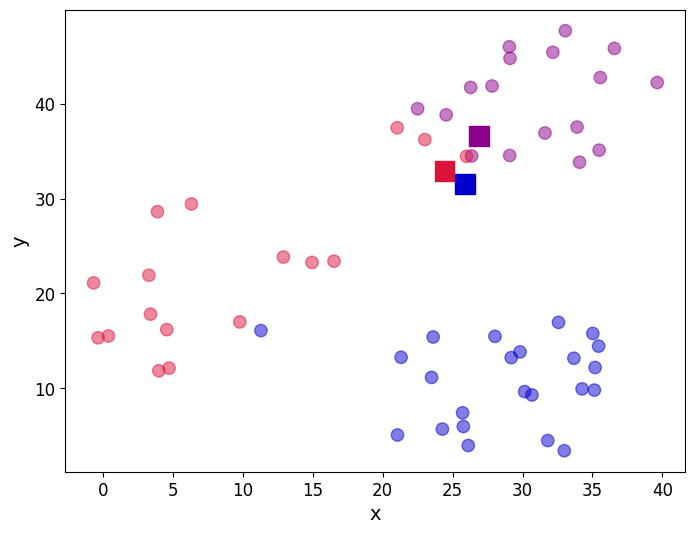

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(df.iloc[:,0], df.iloc[:,1],  marker = 'o',
            c=df['centroid'].astype('category'),
            cmap = customcmap, s=80, alpha=0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],
            marker = 's', s=200, c=[0, 1, 2],
            cmap = customcmap)
ax.set_xlabel(r'x', fontsize=14)
ax.set_ylabel(r'y', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Let us see the total error by adding all the contributions. We will take a look at this error as a measure of convergence. In other words, if the error does not change, we can assume that the centroids have stabilised their location and we can terminate our iterations. In practice, we need to be mindful of having found a local minimum (outside the scope of this post).

In [10]:
print("The total error is {0:.2f}".format(df['error'].sum()))

The total error is 11927659.01


Step 5 - Update centroid location
Now that we have a first attempt at defining our clusters, we need to update the position of the k centroids. We do this by calculating the mean of the position of the observations assigned to each centroid. Let take a look:

In [11]:
centroids = df.groupby('centroid').agg('mean').loc[:, colnames].reset_index(drop = True)
centroids

,x,y
0,9.889444,23.242611
1,28.435750,11.546250
2,30.759333,40.311167


We can verify that the position has been updated. Let us look again at our scatter plot:

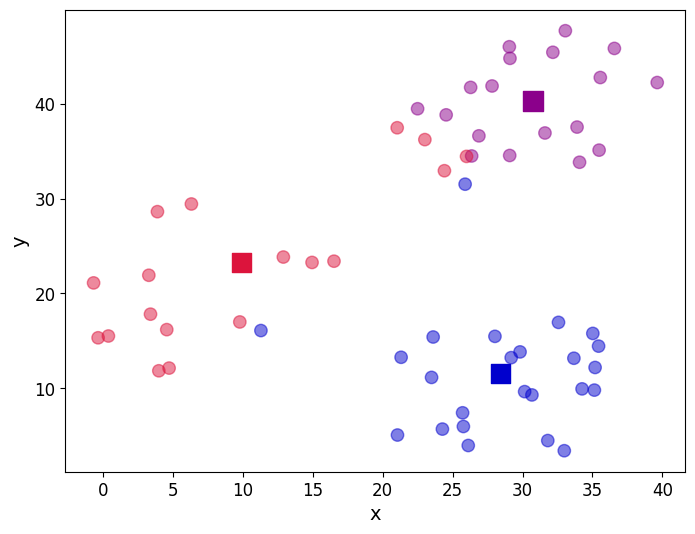

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(df.iloc[:,0], df.iloc[:,1],  marker = 'o',
            c=df['centroid'].astype('category'),
            cmap = customcmap, s=80, alpha=0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],
            marker = 's', s=200,
            c=[0, 1, 2], cmap = customcmap)
ax.set_xlabel(r'x', fontsize=14)
ax.set_ylabel(r'y', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Now we go back to calculate the distance to each centroid, assign observations and update the centroid location. This calls for a function to encapsulate the loop:

In [13]:
def kmeans(dset, k=2, tol=1e-4):
    '''
    K-means implementationd for a
    `dset`:  DataFrame with observations
    `k`: number of clusters, default k=2
    `tol`: tolerance=1E-4
    '''
    # Let us work in a copy, so we don't mess the original
    working_dset = dset.copy()
    # We define some variables to hold the error, the
    # stopping signal and a counter for the iterations
    err = []
    goahead = True
    j = 0

    # Step 2: Initiate clusters by defining centroids
    centroids = initiate_centroids(k, dset)

    while(goahead):
        # Step 3 and 4 - Assign centroids and calculate error
        working_dset['centroid'], j_err = centroid_assignation(working_dset, centroids)
        err.append(sum(j_err))

        # Step 5 - Update centroid position
        centroids = working_dset.groupby('centroid').agg('mean').reset_index(drop = True)

        # Step 6 - Restart the iteration
        if j>0:
            # Is the error less than a tolerance (1E-4)
            if err[j-1]-err[j]<=tol:
                goahead = False
        j+=1

    working_dset['centroid'], j_err = centroid_assignation(working_dset, centroids)
    centroids = working_dset.groupby('centroid').agg('mean').reset_index(drop = True)
    return working_dset['centroid'], j_err, centroids

OK, we are now ready to apply our function. We will clean our dataset first and let the algorithm run:

In [14]:
np.random.seed(42)
df['centroid'], df['error'], centroids =  kmeans(df[['x','y']], 3)
df.head()

,x,y,centroid,error
0,24.412,32.932,2,3767.568743
1,35.190,12.189,1,1399.889001
2,26.288,41.718,2,262.961097
3,0.376,15.506,0,2683.086425
4,26.116,3.963,1,2723.650198


As we can see the three groups have been obtained. In this particular example the data is such that the distinction between the groups is clear. However, we may not be as lucky in every case. So the question about how many groups there are still remains. We can use a screen plot to help us with the error minimisation by looking at running the algorithm with a sequence
k
=
1
,
2
,
3
,
4
,
.
.
.
 and look for the “elbow” in the plot indicating a good number of clusters to use:





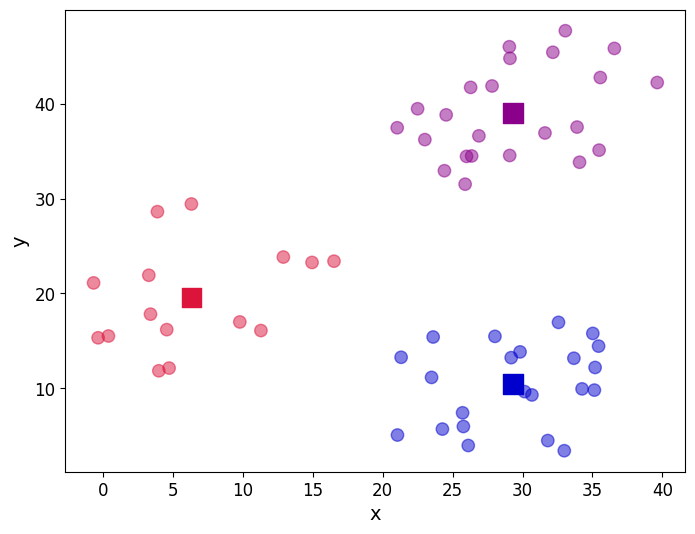

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(df.iloc[:,0], df.iloc[:,1],  marker = 'o',
            c=df['centroid'].astype('category'),
            cmap = customcmap, s=80, alpha=0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],
            marker = 's', s=200, c=[0, 1, 2],
            cmap = customcmap)
ax.set_xlabel(r'x', fontsize=14)
ax.set_ylabel(r'y', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

We can now apply the “elbow rule” which is a heuristic to help us determine the number of clusters. If we think of the line shown above as depicting an arm, then the “elbow” is the point of inflection. In this case the “elbow” is located between 2 and 4 clusters, giving us an indication that choosing 3 is a good fit.

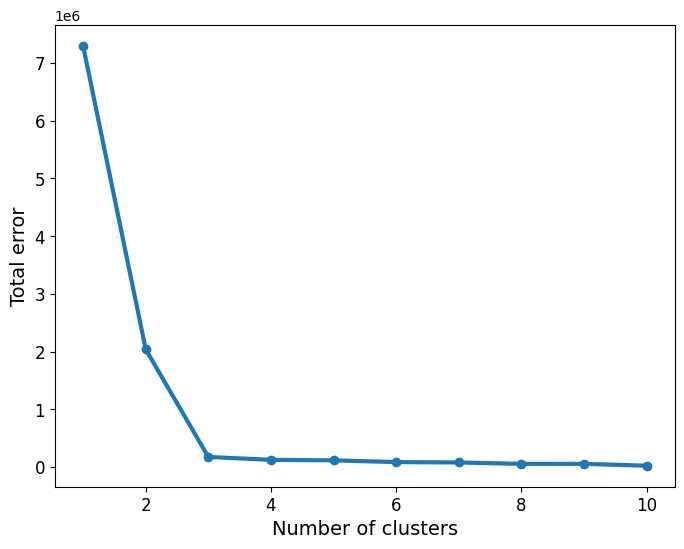

In [16]:
err_total = []
n = 10

df_elbow = blobs[['x','y']]

for i in range(n):
    _, my_errs, _ = kmeans(df_elbow, i+1)
    err_total.append(sum(my_errs))
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(range(1,n+1), err_total, linewidth=3, marker='o')
ax.set_xlabel(r'Number of clusters', fontsize=14)
ax.set_ylabel(r'Total error', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# **K-Means using Scikit-learn**
We have seen how to make an initial implementation of the algorithm, but in many cases you may want to stand on the shoulders of giants and use other tried and tested modules to help you with your machine learning work. In this case, Scikit-learn is a good choice and it has a very nice implementation for
k
-means.

In this case we will show how k-means can be implemented in a couple of lines of code using the same dataset.

Centroids from original method:
[[ 6.32286667 19.5598    ]
 [29.30495652 39.05078261]
 [29.33086364 10.43240909]]

Centroids from Scikit-Learn:
[[ 6.32286667 19.5598    ]
 [29.30495652 39.05078261]
 [29.33086364 10.43240909]]


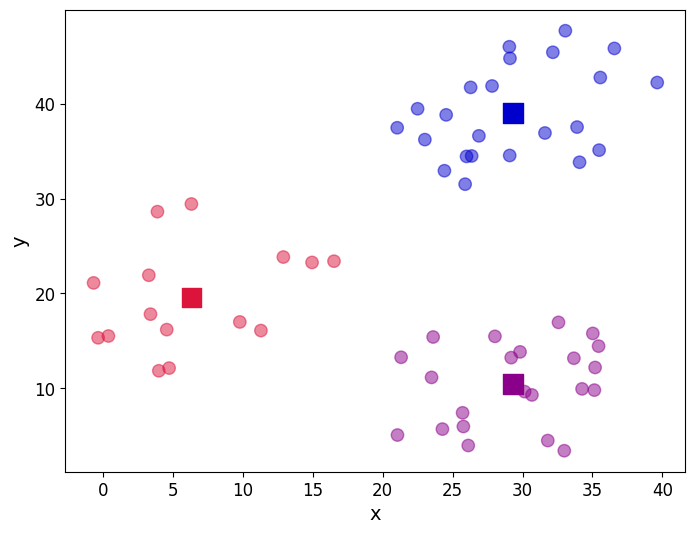

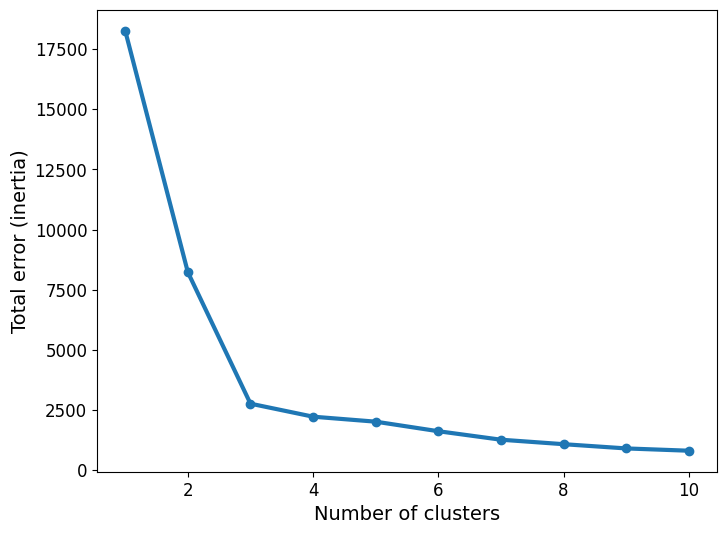

In [28]:
from sklearn.cluster import KMeans

# Load dataset
blobs = pd.read_csv('kmeans_blobs.csv')
df = blobs[['x', 'y']].copy()

# Define number of clusters
k = 3

# Apply K-Means using Scikit-Learn
kmeans = KMeans(n_clusters=k, random_state=42)
df.loc[:, 'centroid'] = kmeans.fit_predict(df)
centroids_sklearn = kmeans.cluster_centers_

# Original method centroids (assuming centroids variable is available from original method)
print("Centroids from original method:")
print(centroids)
print("\nCentroids from Scikit-Learn:")
print(centroids_sklearn)

# Visualization
customcmap = ListedColormap(["crimson", "mediumblue", "darkmagenta"])
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(df['x'], df['y'], marker='o', c=df['centroid'], cmap=customcmap, s=80, alpha=0.5)
plt.scatter(centroids_sklearn[:, 0], centroids_sklearn[:, 1], marker='s', s=200, c=[0, 1, 2], cmap=customcmap)
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Elbow method to determine optimal k
err_total = []
n = 10
for i in range(1, n+1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df[['x', 'y']])
    err_total.append(kmeans.inertia_)

fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(range(1, n+1), err_total, linewidth=3, marker='o')
ax.set_xlabel('Number of clusters', fontsize=14)
ax.set_ylabel('Total error (inertia)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


# **The Iris Dataset**

In this case we will show how k-means can be implemented in a couple of lines of code using the well-known Iris dataset. We can load it directly from Scikit-learn and we will shuffle the data to ensure the points are not listed in any particular order.



In [17]:
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.utils import shuffle

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
names = iris.feature_names
X, y = shuffle(X, y, random_state=42)

In [18]:
model = KMeans(n_clusters=3, random_state=42)
iris_kmeans = model.fit(X)

In [19]:
iris_kmeans.labels_

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 1,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 2, 1, 2, 1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 2, 0, 1, 1, 0, 1, 1, 1, 1, 2, 1, 0, 1, 2, 0, 0, 1, 2, 0, 1, 0,
       0, 1, 1, 2, 1, 2, 2, 1, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 2, 2, 0, 1,
       1, 1, 1, 2, 0, 2, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 2, 2,
       0, 2, 0, 2, 2, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 1, 2], dtype=int32)

In [20]:
y = np.choose(y, [1, 2, 0]).astype(int)
y

array([2, 1, 0, 2, 2, 1, 2, 0, 2, 2, 0, 1, 1, 1, 1, 2, 0, 2, 2, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, 1, 1, 1, 0, 2, 2, 1,
       1, 2, 0, 0, 2, 0, 2, 0, 2, 1, 0, 2, 1, 1, 1, 2, 0, 1, 1, 1, 2, 1,
       2, 0, 1, 2, 0, 1, 0, 0, 2, 2, 0, 2, 1, 2, 0, 1, 1, 2, 2, 1, 0, 1,
       1, 2, 2, 0, 2, 0, 0, 2, 1, 1, 0, 0, 1, 1, 1, 2, 0, 1, 0, 0, 1, 2,
       2, 0, 2, 0, 1, 0, 2, 0, 2, 2, 2, 1, 2, 2, 1, 2, 0, 0, 1, 2, 0, 0,
       1, 0, 1, 2, 0, 0, 2, 0, 2, 2, 0, 0, 1, 2, 0, 1, 2, 0])

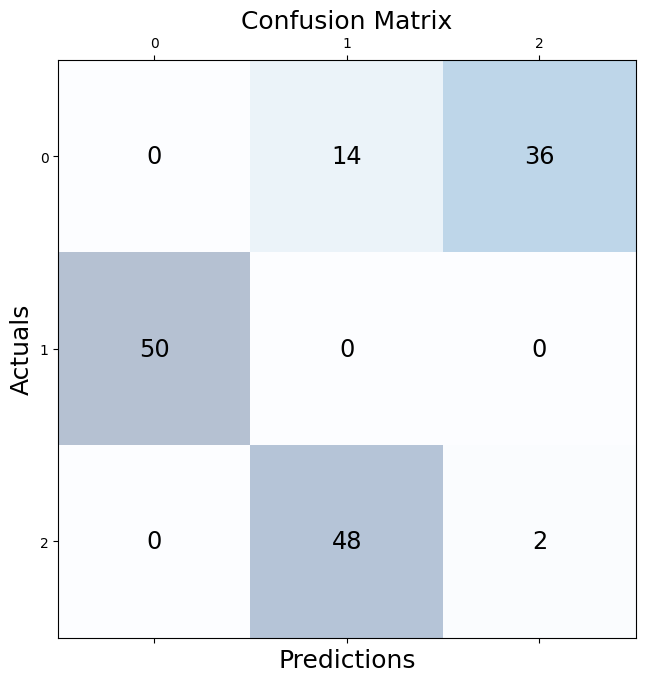

In [21]:
from sklearn.metrics import confusion_matrix
conf_matrix=confusion_matrix(y, iris_kmeans.labels_)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center',
                ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [22]:
iris_kmeans.cluster_centers_

array([[5.006     , 3.428     , 1.462     , 0.246     ],
       [5.9016129 , 2.7483871 , 4.39354839, 1.43387097],
       [6.85      , 3.07368421, 5.74210526, 2.07105263]])

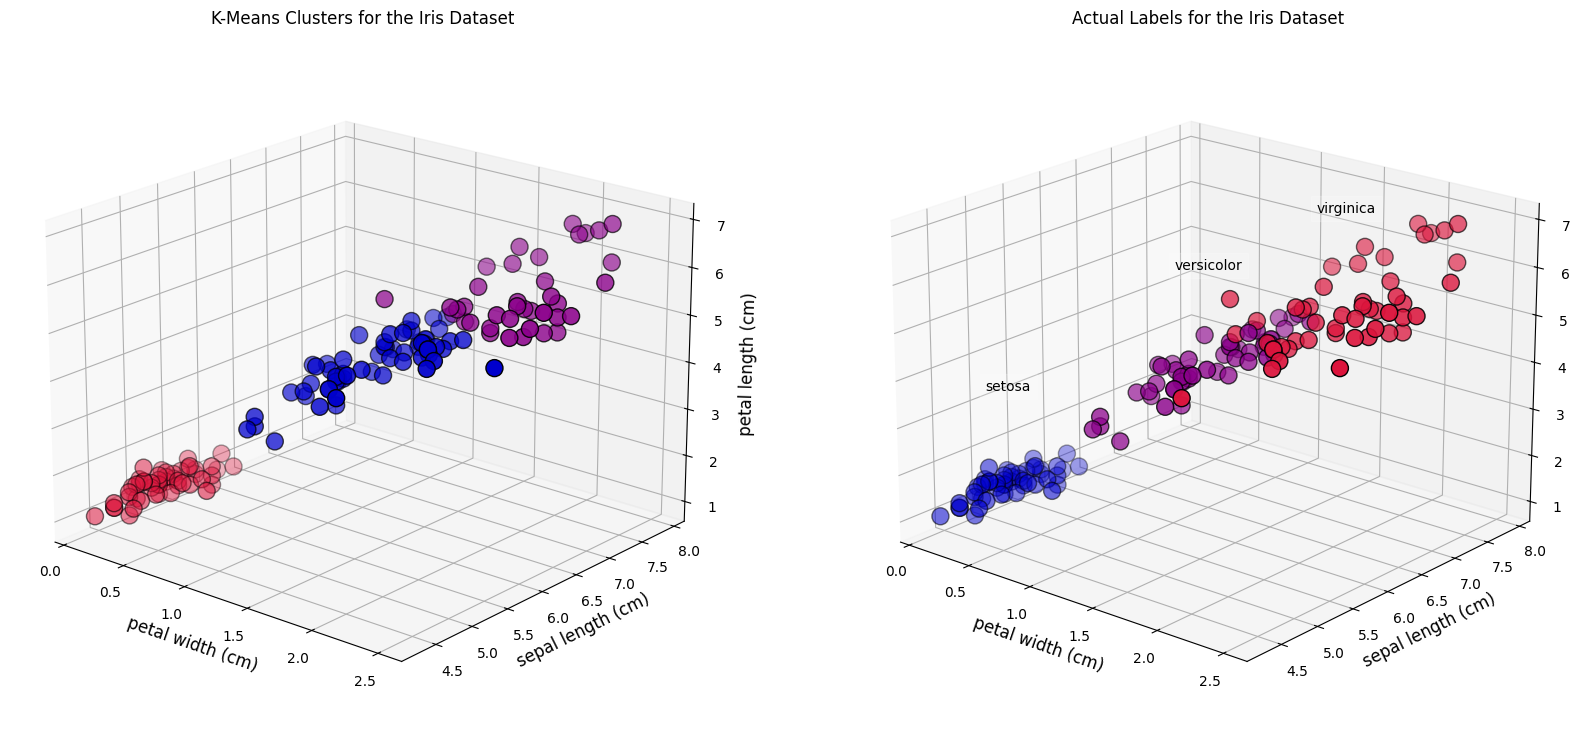

In [23]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.scatter(X[:, 3], X[:, 0], X[:, 2],
            c=iris_kmeans.labels_.astype(float),
           edgecolor="k", s=150, cmap=customcmap)
ax1.view_init(20, -50)
ax1.set_xlabel(names[3], fontsize=12)
ax1.set_ylabel(names[0], fontsize=12)
ax1.set_zlabel(names[2], fontsize=12)
ax1.set_title("K-Means Clusters for the Iris Dataset", fontsize=12)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')

for label, name in enumerate(['virginica','setosa','versicolor']):
    ax2.text3D(
        X[y == label, 3].mean(),
        X[y == label, 0].mean(),
        X[y == label, 2].mean() + 2,
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.2, edgecolor="w", facecolor="w"),
    )

ax2.scatter(X[:, 3], X[:, 0], X[:, 2],
            c=y, edgecolor="k", s=150,
            cmap=customcmap)
ax2.view_init(20, -50)
ax2.set_xlabel(names[3], fontsize=12)
ax2.set_ylabel(names[0], fontsize=12)
ax2.set_zlabel(names[2], fontsize=12)
ax2.set_title("Actual Labels for the Iris Dataset", fontsize=12)
fig.show()